## Track and featurize cells after segmentation

Load segmentation h5 files, track cells between frames, calculate features, save to h5

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/groups/ZuckermanLab/copperma/cell/celltraj/celltraj')
import os
import imageprep as imprep
import trajectory
import utilities
import features
import cmapfile
import pathlib
from skimage import transform as tf
import skimage.filters
from skimage.measure import regionprops_table
from IPython.display import clear_output
import os

##### Specify segmentation model files

In [43]:
date = '2024.03.18'
modelName = f'20240213_T4lung_VM' #results will be saved/named using this string
datapath='/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM'
modelList = imprep.list_images(f'{datapath}/{modelName}_xy*_roi*.h5')
print(modelList)

['/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy0_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy10_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy13_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy14_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy1_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy2_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy3_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy4_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy5_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/

In [44]:
modelList=np.array(modelList)[[1,2,3,7,8,9,10,11,12]];print(modelList)

['/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy10_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy13_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy14_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy4_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy5_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy6_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy7_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy8_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy9_roi0.h5']


In [5]:
#some convenience visualization functions here, eventually these will be incorporated into the packages....
def show_image_3channel(bf_img,nuc_img,rep_img,ax=None):
        if ax is None:
            ax=plt.gca()
        ax.imshow(imprep.znorm(bf_img),cmap=plt.cm.binary,clim=(-5,5))
        cs=ax.contour(imprep.znorm(nuc_img),cmap=plt.cm.BuPu,levels=np.linspace(0,np.percentile(imprep.znorm(nuc_img),99),7),alpha=.5,linewidths=.5)
        cs.cmap.set_over('purple')
        cs=ax.contour(imprep.znorm(rep_img),cmap=plt.cm.YlOrBr_r,levels=np.linspace(0,np.percentile(imprep.znorm(rep_img),99),7),alpha=.25,linewidths=.5)
        cs.cmap.set_over('yellow')
        return ax

def rescale_to_int(img,maxint=255,dtype=np.uint16):
    img=maxint*((img-np.min(img))/np.max(img-np.min(img)))
    return img.astype(dtype)

def show_3dseg_zproj(fig,im3d,labels,fmap=None,fmapscale=None,labels2=None,fmsk=None):
    zproj=np.sum(im3d,axis=0)
    labels_zproj=np.max(labels,axis=0)
    plt.imshow(zproj,cmap=plt.cm.gray_r)
    plt.contour(labels_zproj,levels=np.arange(np.max(labels_zproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=0),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_zproj=np.max(labels2,axis=0)
        plt.contour(labels2_zproj,levels=np.arange(np.max(labels2_zproj)),colors='green',linewidths=1)
    if fmsk is not None:
        fmsk_zproj=np.max(fmsk,axis=0)
        plt.contour(fmsk_zproj,levels=np.arange(np.max(fmsk_zproj)),colors='red',linewidths=1)    
    plt.axis('equal');plt.axis('off')

def log_ztransform(img):
    img=np.log(imprep.znorm(img)+1.-np.min(imprep.znorm(img)))
    return img

def nuc_viewtransform(im3d_nuc,zcut_nuc=2.0,rsmooth=1.0,zscale=5.0):
    im3d_nuc=skimage.filters.gaussian(im3d_nuc,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_nuc=imprep.znorm(im3d_nuc)
    im3d_nuc[im3d_nuc<zcut_nuc]=0
    im3d_nuc=rescale_to_int(log_ztransform(im3d_nuc))
    return im3d_nuc

def bf_viewtransform(im3d_bf,rsmooth=10.0,zscale=5.0,zcut=2.0,remove_background=False):
    im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
    if remove_background:
        im3d_bf_smth=skimage.filters.gaussian(np.abs(im3d_bf),sigma=[rsmooth/zscale,rsmooth,rsmooth])
        msk_bf=imprep.znorm(im3d_bf_smth)>zcut
        msk_bf=binary_fill_holes_2dstack(msk_bf)
    im3d_bf=rescale_to_int(log_ztransform(im3d_bf))
    im3d_bf=np.max(im3d_bf)-im3d_bf
    if remove_background:
        im3d_bf[np.logical_not(msk_bf)]=0
    return im3d_bf

def rep_viewtransform(im3d_rep,rsmooth=1.0,zscale=5.0):
    im3d_rep=skimage.filters.gaussian(im3d_rep,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_rep=rescale_to_int(log_ztransform(im3d_rep))
    return im3d_rep

def binary_fill_holes_2dstack(im3d):
    for iz in range(im3d.shape[0]):
        im3d[iz,...]=ndimage.binary_fill_holes(im3d[iz,...])
    return im3d

##### Loop through model files, track, featurize, and save

In [45]:
for h5filename in modelList:
    try:
        sctm=trajectory.Trajectory(h5filename=h5filename)
        sctm.get_image_shape()
        print(f'{sctm.nmaskchannels}')
        sctm.get_frames()
        nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['Cy5']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        #fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        sctm.get_cell_index(verbose=True,save_h5=True,overwrite=True)
        ntrans=[1,1,1]
        maxt=[0.,0.,0.]
        tf_matrix_set=sctm.get_stack_trans(mskchannel=0,ntrans=ntrans,maxt=maxt,dist_function=utilities.get_pairwise_distance_sum,save_h5=True,overwrite=True,do_global=False) #,contact_transform=True,r0=100.,d0=100.,n=6,m=12)
        clear_output(wait=True)
        x=sctm.get_cell_positions(save_h5=True,overwrite=True)
        clear_output(wait=True)
        tf_matrix_set_pad,pad_dims=imprep.get_registration_expansions(sctm.tf_matrix_set,sctm.nz,sctm.nx,sctm.ny)
        clear_output(wait=True)
        #linSet=sctm.get_lineage_btrack(mskchannel=0,distcut=3*sctm.cellpose_diam,framewindow=6,visual=True,max_search_radius=5*sctm.cellpose_diam,save_h5=True,overwrite=True)
        linSet=sctm.get_lineage_mindist(distcut=3*sctm.cellpose_diam,visual=True,save_h5=True,overwrite=True)
        clear_output(wait=True)
        #Bright field features with cyto masks
        Xf,feature_list=sctm.get_cell_features((features.featZernike,features.featHaralick,features.featBoundary),indcells=None,imgchannel=bf_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True)
        #foreground mask boundary features
        clear_output(wait=True)
        bordersize=int(sctm.cellpose_diam/5.)
        Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,imgchannel=0,mskchannel=cyto_msk_channel,use_fmask_for_intensity_image=True,bordersize=bordersize,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        clear_output(wait=True)
        #Reporter features with cyto masks
        #Xf,feature_list=sctm.get_cell_features((features.featZernike,features.featHaralick),indcells=None,imgchannel=rep_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        #nuclear features with cyto masks
        #Xf,feature_list=sctm.get_cell_features((features.featZernike,features.featHaralick),indcells=None,imgchannel=nuc_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        #nuclear shape features with cyto masks, nuc masks as intensity image
        #Xf,feature_list=sctm.get_cell_features((features.featNucBoundary),indcells=None,use_mask_for_intensity_image=True,imgchannel=nuc_msk_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        #boundary features to monitor cancer cell neighbors
        Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,use_mask_for_intensity_image=True,apply_contact_transform=True,bordersize=int(bordersize/2),imgchannel=cyto_msk_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        clear_output(wait=True)
        #Xf,feature_list=sctm.get_cell_features((features.totalIntensity),indcells=None,imgchannel=fra1_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        #clear_output(wait=True)
        #Xf,feature_list=sctm.get_cell_features((features.meanIntensity),indcells=None,imgchannel=fra1_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        #clear_output(wait=True)
        #motility features
        #Xf_com=sctm.get_motility_features(mskchannel=cyto_msk_channel,save_h5=True,overwrite=True)
        #clear_output(wait=True)
        #signaling features
        corrc_erk=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=erk_img_channel,save_h5=True,overwrite=True)
        corrc_erk=1.-corrc_erk
        clear_output(wait=True)
        cratio_erk=sctm.get_cell_compartment_ratio(imgchannel=erk_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=nuc_msk_channel,make_disjoint=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        corrc_akt=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=akt_img_channel,save_h5=True,overwrite=True)
        corrc_akt=1.-corrc_akt
        clear_output(wait=True)
        cratio_akt=sctm.get_cell_compartment_ratio(imgchannel=akt_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=nuc_msk_channel,make_disjoint=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        #fra1_nuc=sctm.get_cell_compartment_ratio(imgchannel=fra1_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=nuc_msk_channel,make_disjoint=True,noratio=True,save_h5=True,overwrite=True)
        #clear_output(wait=True)
    except Exception as e:
        print(e)

featurizing cells from frame 0
featurizing cells from frame 1
featurizing cells from frame 2
featurizing cells from frame 3
featurizing cells from frame 4
featurizing cells from frame 5
featurizing cells from frame 6
featurizing cells from frame 7
featurizing cells from frame 8
featurizing cells from frame 9
featurizing cells from frame 10
featurizing cells from frame 11
featurizing cells from frame 12
featurizing cells from frame 13
featurizing cells from frame 14
featurizing cells from frame 15
featurizing cells from frame 16
featurizing cells from frame 17
featurizing cells from frame 18
featurizing cells from frame 19
featurizing cells from frame 20
featurizing cells from frame 21
featurizing cells from frame 22
featurizing cells from frame 23
featurizing cells from frame 24
saving attributes ['img0_m0m1_ratio'] to /cell_data/ in /home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy9_roi0.h5
error saving img0_m0m1_ratio to /home/groups/CEDAR/

In [47]:
print(modelList)

['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy3_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy4_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy5_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy8_roi1.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy9_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy9_roi1.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy15_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy16_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy16_roi1.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/

In [45]:
importlib.reload(trajectory)

<module 'trajectory' from '/home/groups/ZuckermanLab/copperma/cell/celltraj/celltraj/trajectory.py'>

In [13]:
if True:
        corrc_erk=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=erk_img_channel,save_h5=True,overwrite=True)
        corrc_erk=1.-corrc_erk
        clear_output(wait=True)
        cratio_erk=sctm.get_cell_compartment_ratio(imgchannel=erk_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=nuc_msk_channel,make_disjoint=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        corrc_akt=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=akt_img_channel,save_h5=True,overwrite=True)
        corrc_akt=1.-corrc_akt
        clear_output(wait=True)
        cratio_akt=sctm.get_cell_compartment_ratio(imgchannel=akt_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=nuc_msk_channel,make_disjoint=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)

featurizing cells from frame 0
featurizing cells from frame 1
featurizing cells from frame 2
featurizing cells from frame 3
featurizing cells from frame 4
featurizing cells from frame 5
featurizing cells from frame 6
featurizing cells from frame 7
featurizing cells from frame 8
featurizing cells from frame 9
featurizing cells from frame 10
featurizing cells from frame 11
featurizing cells from frame 12
featurizing cells from frame 13
featurizing cells from frame 14
featurizing cells from frame 15
featurizing cells from frame 16
featurizing cells from frame 17
featurizing cells from frame 18
featurizing cells from frame 19
featurizing cells from frame 20
featurizing cells from frame 21
featurizing cells from frame 22
featurizing cells from frame 23
featurizing cells from frame 24
saving attributes ['img0_m0m1_ratio'] to /cell_data/ in /home/groups/CEDAR/copperma/dyn-cell-sys/Vaibhav/240213_ms_lung_w_t4_VM/20240213_T4lung_VM_xy0_roi0.h5
error saving img0_m0m1_ratio to /home/groups/CEDAR/

(-2.0, 2.0)

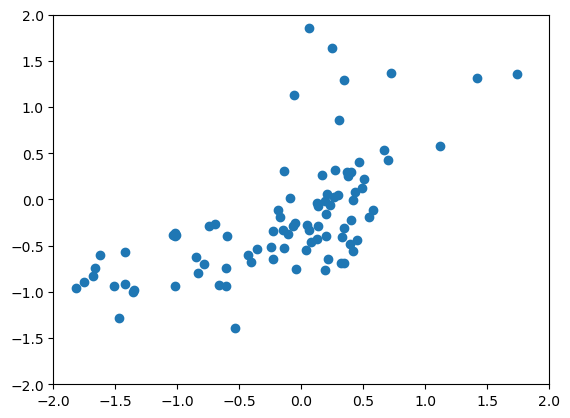

In [18]:
cratio_erk=imprep.znorm(sctm.img2_m0m1_ratio)
corrc_erk=imprep.znorm(1.-np.array(sctm.m0_img1img2_crosscorr))
plt.clf()
plt.scatter(corrc_erk,cratio_erk)
plt.xlim(-2,2)
plt.ylim(-2,2)

(-2.0, 2.0)

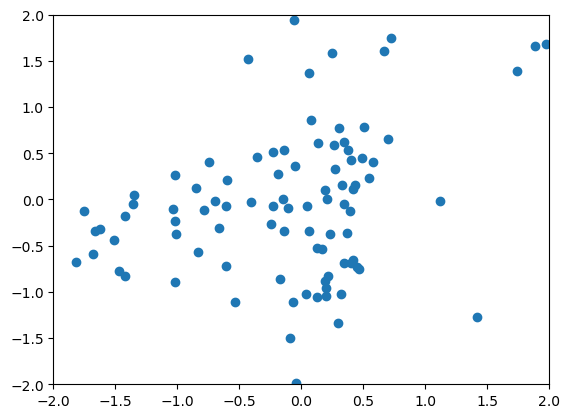

In [19]:
cratio_akt=imprep.znorm(sctm.img0_m0m1_ratio)
corrc_akt=imprep.znorm(1.-np.array(sctm.m0_img1img2_crosscorr))
plt.clf()
plt.scatter(corrc_akt,cratio_akt)
plt.xlim(-2,2)
plt.ylim(-2,2)

In [16]:
erk_img_channel

2

In [23]:
fra1_tot=imprep.znorm(Xf[:,feature_list=='totalIntensity_msk0img1'])
fra1_mean=imprep.znorm(Xf[:,feature_list=='meanIntensity_msk0img1'])
fra1_nuc=imprep.znorm(sctm.img1_m0m1_ratio)

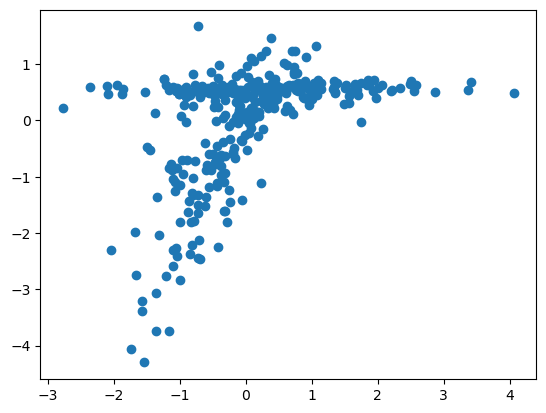

In [33]:
plt.scatter(cratio_erk,cratio_akt)

In [17]:
sctm.channels

array([b'TRITC', b'Cy5', b'YFP', b'BF'], dtype='|S32')

In [14]:
print(modelList[2:])

['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy15_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy16_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy16_roi1.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy18_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy19_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy3_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy4_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy5_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20240302_OS17lung_RM/20240302_OS17lung_RM_xy6_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sy